# Stock Prediction using Regression Methods from SciKit-Learn

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Reading files, definition of Start and End Date
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

# Reading Target Value
dft = web.DataReader("CCL", 'yahoo', start, end)
dft.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,32.759998,31.959999,32.290001,32.060001,5372700.0,24.283934
2010-01-05,32.540001,32.200001,32.279999,32.369999,3199900.0,24.518740
2010-01-06,32.570000,31.750000,32.290001,31.790001,6171400.0,24.079418
2010-01-07,32.360001,31.900000,32.119999,32.139999,3469400.0,24.344534
2010-01-08,33.290001,32.639999,32.820000,33.220001,4950500.0,25.162582


In [3]:
# Reading Values for Competitors / Correlations
dfc = web.DataReader(['TUI1.DE', '^GSPC', 'GOOG', 'IBM', 'MSFT', 'GOLD'],'yahoo',
                               start=start, 
                               end=end)['Adj Close']
dfc.head()

Symbols,GOLD,GOOG,IBM,MSFT,TUI1.DE,^GSPC
Date,,,,,,
2010-01-04,35.084915,312.204773,98.142967,24.443624,4.274405,1132.989990
2010-01-05,35.519253,310.829926,96.957375,24.451517,4.488549,1136.520020
2010-01-06,36.274986,302.994293,96.327530,24.301458,4.547915,1137.140015
2010-01-07,35.762482,295.940735,95.994110,24.048725,4.682198,1141.689941
2010-01-08,35.988331,299.885956,96.957375,24.214581,4.854643,1144.979980


In [4]:
#Creating "neutral" dataframe - if you change stocks you don't have to modify the changes later
dfc2 = dfc.loc[:,['GOLD']]
dfc2['comp1'] = dfc['GOLD']
dfc2['comp2'] = dfc['GOOG']
dfc2['comp3'] = dfc['IBM']
dfc2['comp4'] = dfc['MSFT']
dfc2['comp5'] = dfc['TUI1.DE']
dfc2['comp6'] = dfc['^GSPC']
del dfc2['GOLD']
dfc2.tail(10)


Symbols,comp1,comp2,comp3,comp4,comp5,comp6
Date,,,,,,
2019-08-26,19.201405,1168.890015,129.990005,135.449997,9.010,2878.379883
2019-08-27,19.730343,1167.839966,131.169998,135.740005,9.142,2869.159912
2019-08-28,19.900002,1171.020020,132.759995,135.559998,9.056,2887.939941
2019-08-29,19.280001,1192.849976,134.880005,138.119995,9.052,2924.580078
2019-08-30,19.379999,1188.099976,135.529999,137.860001,9.038,2926.459961
2019-09-02,NaN,NaN,NaN,NaN,9.098,NaN
2019-09-03,19.420000,1168.390015,134.100006,136.039993,9.186,2906.270020
2019-09-04,19.870001,1181.410034,136.320007,137.630005,9.338,2937.780029
2019-09-05,18.400000,1211.380005,140.970001,140.050003,9.500,2976.000000


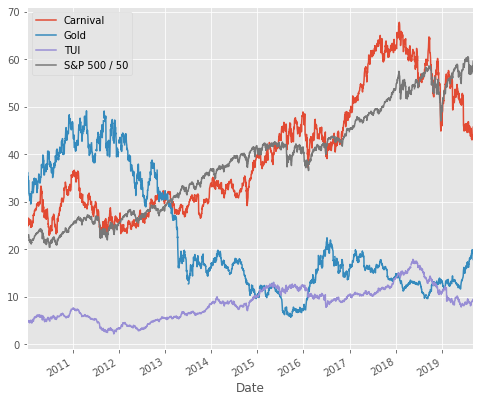

In [5]:
# Plotting
mpl.rc('figure', figsize=(8, 7))
style.use('ggplot')

CCL = dft['Adj Close']
GOLD = dfc['GOLD']
SP500 = dfc['^GSPC']
SP500 = SP500/50# Divided by 50 to fit in graph
TUI =  dfc['TUI1.DE']

CCL.plot(label='Carnival')
GOLD.plot(label='Gold')
TUI.plot(label='TUI')
SP500.plot(label='S&P 500 / 50')

plt.legend();

## Feature Engineering
**Input Matrix X: Values from previous day**
 - Adj Close
 - Volume
 - High- low percentage
 - Change Intraday
 - Change between last 2 day
 - Change between last 2 days of competitors and other stocks
 
**Output Vector y**
 - Contains Adj Close

In [6]:
# Creating Dataframe for X and y


# Feature 1 & 2: Close Course, Volume
dfz = dft.loc[:,['Adj Close','Volume']] # Adds Colums to dfz

# Feature 3: High Low Percentage
  
dfz['HL_PCT'] = (dft['High'] - dft['Low']) / dft['Close'] * 100.0 #(high-low) / close

#Feature 4: Day Change
dfz['day_change'] = (dft['Close'] - dft['Open']) / dft['Open'] * 100.0 # Neuer Wert hinzu

# Feature 5: Change of adj close between 2 days:
dfz['pct_change'] = dfz['Adj Close'].pct_change()

#Feature 6-11
dfc2.interpolate(method = 'linear', inplace = True)
dfc2 = dfc2.pct_change()

dfz = pd.concat([dfz, dfc2], axis=1)


# Interpolate missing Values 
dfz.interpolate(method = 'linear', inplace = True)

#create Label
#dflabel = dfz['Adj Close']
dfz['Label'] = dfz['Adj Close'].shift(-1)


#Drop na
dfz = dfz.dropna() 

In [7]:
#Scaling, create array

# X = Feature matrix without label
X = np.array(dfz.drop(['Label'], 1)) 

# y = label
y = np.array(dfz['Label'])

# Scaling
X = preprocessing.scale(X)

# Seperate last 10 datasets for final Test
X_final = X[-10:]
X = X[:-10]
y_final = y[-10:]
y = y[:-10]


print("Size of X:",X.shape)
print("Size of X_final:",X_final.shape)
print("Size of y:",y.shape)

Size of X: (2488, 11)
Size of X_final: (10, 11)
Size of y: (2488,)


## Prediction
**Prediction**
 - Linear Regression
 - Lasso Regression
 - Polynominal Regression

In [8]:
# Separation of training and testing of model by train test split, shuffles data automatically
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Size of X_train:",X_train.shape)
print("Size of X_test:",X_test.shape)
print("Size of y_train:",y_train.shape)
print("Size of y_train:",y_test.shape)

Size of X_train: (1990, 11)
Size of X_test: (498, 11)
Size of y_train: (1990,)
Size of y_train: (498,)


### Linear Regression

The linear regression confidence is  0.9968424780721005


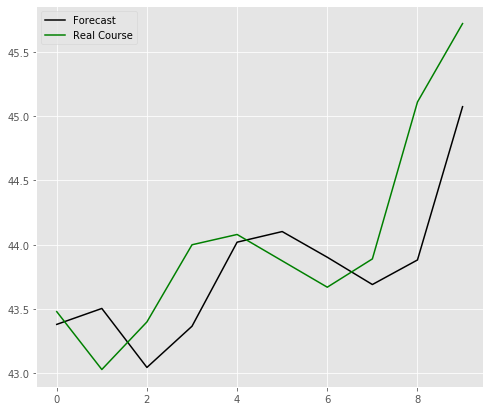

In [20]:
# Printing the forecast
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
confidencereg = clfreg.score(X_test, y_test)
print("The linear regression confidence is ",confidencereg)

# Testing on last X, y final
forecast_lin = clfreg.predict(X_final)

vec = np.arange(len(forecast_lin))
plt.plot(vec, forecast_lin,'k', label="Forecast")
plt.plot(vec, y_final, 'g', label="Real Course")
plt.legend();

### Lasso Regressoion

The Lasso regression confidence is  0.9968471317410612


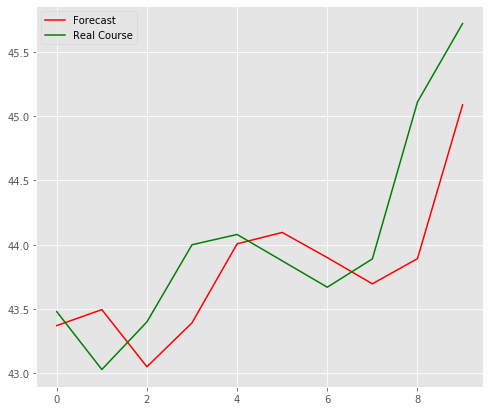

In [19]:
# Printing the forecast
# Lasso regression
clflasso = Lasso(alpha=0.005)
clflasso.fit(X_train, y_train)
confidencereg = clflasso.score(X_test, y_test)
print("The Lasso regression confidence is ",confidencereg)

# Testing on last X, y final
forecast_las = clflasso.predict(X_final)

vec = np.arange(len(forecast_las))
plt.plot(vec, forecast_las,'r', label="Forecast")
plt.plot(vec, y_final, 'g', label="Real Course")
plt.legend();

## Polynominal

Shape of X_train:  (1990, 11)
Shape of X_train poly:  (1990, 364)
The linear regression confidence is  0.9907535712289098


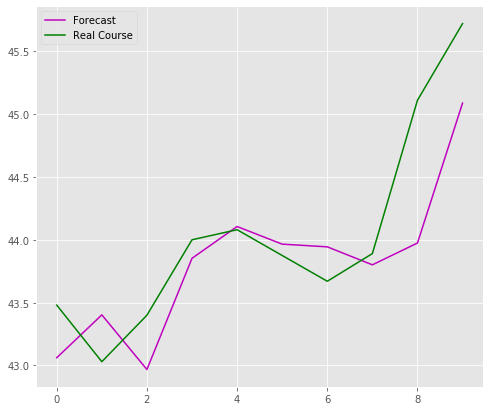

In [18]:
# Extending Matrix X with polynominal features
poly = PolynomialFeatures(degree=3)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_train poly: ", poly.fit_transform(X_train).shape)

# Use Linear regression on extended features
clfpol = LinearRegression(n_jobs=-1)
clfpol.fit(poly.fit_transform(X_train), y_train)
confidencereg = clfpol.score(poly.fit_transform(X_test), y_test)
print("The linear regression confidence is ",confidencereg)

# Testing on last X, y final
forecast_pol = clfpol.predict(poly.fit_transform(X_final))

vec = np.arange(len(forecast_pol))
plt.plot(vec, forecast_pol,'m', label="Forecast")
plt.plot(vec, y_final, 'g', label="Real Course")
plt.legend();

## Comparison

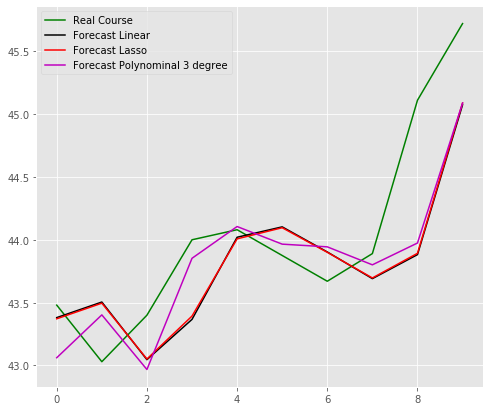

In [17]:
vec = np.arange(len(forecast_pol))
plt.plot(vec, y_final, 'g', label="Real Course")
plt.plot(vec, forecast_lin,'k', label="Forecast Linear")
plt.plot(vec, forecast_las,'r', label="Forecast Lasso")
plt.plot(vec, forecast_pol,'m', label="Forecast Polynominal 3 degree")
plt.legend();
